____
__Universidad de San Andrés__<br/>
__Machine Learning__<br/>
__Detección de ballenas__<br/>
__Martin Bianchi y Federico Gutman__
____

nota: haria dos notebooks, uno para el primer dataset y otro para el segundo

### Importamos las librerías necesarias

In [3]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio

### Cargamos los datos y los visualizamos 

In [4]:
train_dir = r'C:\Users\bianc\Machine\TPFINAL\data\whale-detection-challenge\data\train'

train_files = [f for f in os.listdir(train_dir) if f.endswith('.aiff')]

test_dir = r'C:\Users\bianc\Machine\TPFINAL\data\whale-detection-challenge\data\test'

test_files = [f for f in os.listdir(test_dir) if f.endswith('.aiff')]


In [23]:
train_dir = r'C:\Users\bianc\Machine\TPFINAL\data\whale-detection-challenge\data\train'
labels_df = pd.read_csv(r'C:\Users\bianc\Machine\TPFINAL\data\whale-detection-challenge\data\train.csv')

# Selección balanceada
sample_df = pd.concat([
    labels_df[labels_df.label == 1].sample(5, random_state=1),
    labels_df[labels_df.label == 0].sample(5, random_state=1)
])

# Audio
sample_df['filepath'] = sample_df['clip_name'].apply(lambda x: os.path.join(train_dir, x))
sample_df['audio'] = sample_df['filepath'].apply(lambda path: librosa.load(path, sr=2000)[0])

Antes de avanzar con modelos de clasificación o estrategias de detección, es fundamental realizar una inspección visual de las señales crudas. Esto nos permite tener una primera intuición sobre las diferencias entre los clips que contienen llamadas de ballenas (**positivos**) y aquellos que no (**negativos**).

En esta sección analizamos las **formas de onda de 10 clips seleccionados**, cinco correspondientes a la clase positiva y cinco a la clase negativa. Cada señal fue muestreada a 2000 Hz y normalizada por `librosa` durante la carga, permitiendo una comparación visual directa.

La **visualización conjunta** en una sola figura con múltiples subgráficos facilita la comparación inmediata y la detección de patrones o anomalías entre clases. Observar las diferencias en **amplitud**, **estructura temporal** y **variabilidad** puede proporcionar pistas valiosas sobre qué tipo de información puede resultar discriminativa al momento de extraer features.

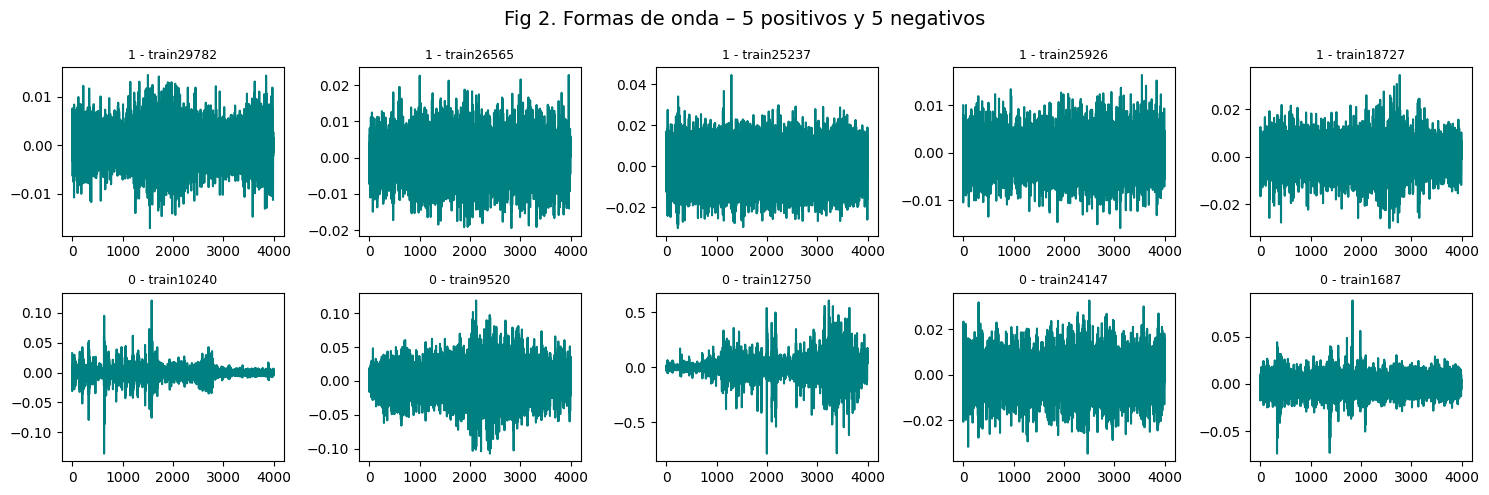

In [26]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5), sharex=False, sharey=False)
axes = axes.flatten()

for i, (idx, row) in enumerate(sample_df.iterrows()):
    audio = row['audio']
    axes[i].plot(audio, color='teal')
    short_name = row['clip_name'].split('.')[0]
    axes[i].set_title(f"{row['label']} - {short_name}", fontsize=9)
    
fig.suptitle("Fig 2. Formas de onda – 5 positivos y 5 negativos", fontsize=14)
plt.tight_layout()
plt.show()


En la Figura 2 se muestran las formas de onda de 10 clips representativos, divididos en dos filas: la superior contiene clips etiquetados como positivos (con presencia de llamadas de ballenas), mientras que la inferior corresponde a clips negativos.

Lo primero que destaca es la **variabilidad en los rangos de amplitud** entre clases. Mientras que los clips negativos presentan en algunos casos **picos mucho más marcados** (por ejemplo, `train12750` alcanza valores cercanos a ±0.5), los positivos tienden a tener una **amplitud más contenida**, alrededor de ±0.02 en la mayoría de los casos. Esto sugiere que los clips negativos pueden incluir ruidos fuertes o eventos no relacionados con la llamada de ballena, como interferencia o sonidos mecánicos.

A nivel visual, también se observan **diferencias en la estructura temporal**. En los ejemplos positivos, la señal presenta una apariencia más homogénea y densa, con menor presencia de silencios o segmentos claramente diferenciados. En contraste, algunos negativos exhiben **cambios bruscos o transiciones** claras entre zonas activas e inactivas (e.g., `train10240` y `train24147`), lo que podría reflejar eventos de fondo más transitorios.

Otra observación importante es que, pese a estas diferencias generales, **no todos los casos son fácilmente distinguibles a simple vista**, lo cual refuerza la necesidad de un análisis posterior más profundo con técnicas de extracción de características (`feature engineering`) y modelos de clasificación. Sin embargo, esta primera visualización ya permite **hipótesis iniciales sobre posibles indicadores acústicos**, como la energía total o el nivel de variación local, que luego podrán cuantificarse numéricamente.

En resumen, la inspección de las formas de onda permite identificar ciertos patrones globales entre clases, especialmente relacionados con la **amplitud**, la **densidad temporal** y la **presencia de transitorios**, ofreciendo una base sólida para las siguientes etapas del pipeline de análisis acústico.

Para complementar el análisis de formas de onda, representamos ahora los mismos 10 clips mediante sus **espectrogramas**, generados con la `Transformada de Fourier de Ventana Corta (STFT)`.

Este tipo de representación nos permite observar cómo varía la **distribución espectral de energía en el tiempo**, revelando información sobre el contenido frecuencial y su evolución temporal. Mientras que las formas de onda muestran cómo cambia la amplitud de la señal, los espectrogramas muestran **cómo cambia el contenido en frecuencia**, lo cual es particularmente relevante para la detección de llamadas de ballenas, que suelen tener **firmas espectrales características**.

Cada subgráfico fue normalizado individualmente en escala logarítmica para resaltar mejor la estructura interna de cada clip, utilizando una paleta de color donde los tonos más claros indican mayor energía (en dB).

TypeError: mel_frequencies() got an unexpected keyword argument 'n_fft'

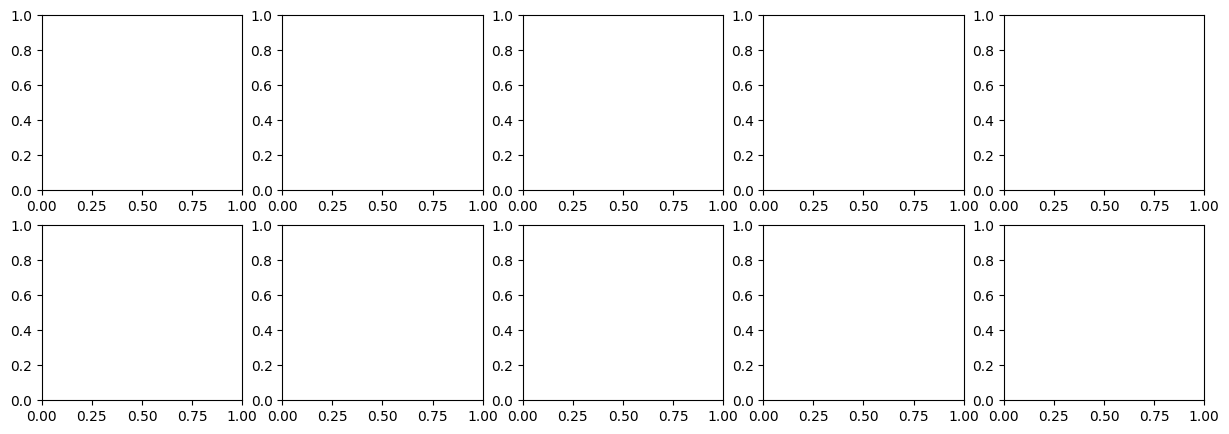

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
axes = axes.flatten()

for i, (idx, row) in enumerate(sample_df.iterrows()):
    S = librosa.stft(row['audio'], n_fft=256, hop_length=128)
    S_dB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
    img = librosa.display.specshow(S_dB, sr=2000, hop_length=128, ax=axes[i],
                                   x_axis=None, y_axis=None, cmap='magma')
    axes[i].set_title(f"{row['label']} - {row['clip_name'].split('.')[0]}", fontsize=9)

fig.suptitle("Fig 3. Espectrogramas STFT (5 positivos y 5 negativos)", fontsize=14)
plt.tight_layout()
plt.colorbar(img, ax=axes, format="%+2.0f dB", shrink=0.5)
plt.show()

cualquiera ni idea

In [29]:
def extract_features(audio, sr=2000):
    features = {
        'zcr': np.mean(librosa.feature.zero_crossing_rate(y=audio)),
        'rms': np.mean(librosa.feature.rms(y=audio)),
        'energy': np.sum(audio**2)
    }
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i+1}'] = np.mean(mfccs[i])
    return features

features_list = [extract_features(audio) for audio in sample_df['audio']]
features_df = pd.DataFrame(features_list)
features_df['label'] = sample_df['label'].values


C:\Users\bianc\AppData\Local\Temp\ipykernel_25732\1624513775.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features_df, x='label', y='energy', ax=axes[0], palette='Set2')
C:\Users\bianc\AppData\Local\Temp\ipykernel_25732\1624513775.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features_df, x='label', y='rms', ax=axes[1], palette='Set2')
C:\Users\bianc\AppData\Local\Temp\ipykernel_25732\1624513775.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=features_df, x='label', y='zcr', ax=axes[2], palette='Set2')


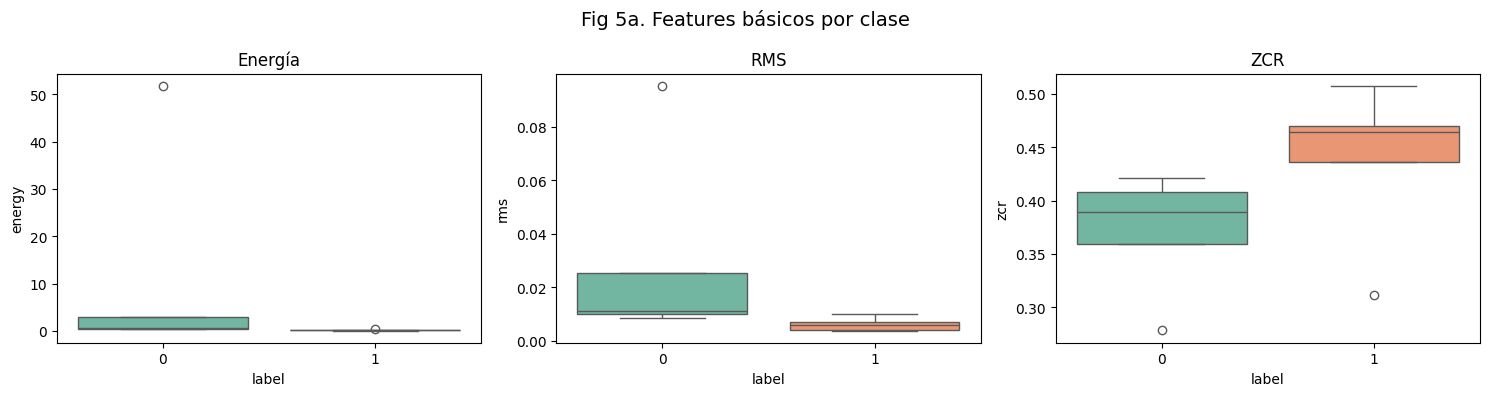

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.boxplot(data=features_df, x='label', y='energy', ax=axes[0], palette='Set2')
axes[0].set_title("Energía")

sns.boxplot(data=features_df, x='label', y='rms', ax=axes[1], palette='Set2')
axes[1].set_title("RMS")

sns.boxplot(data=features_df, x='label', y='zcr', ax=axes[2], palette='Set2')
axes[2].set_title("ZCR")

fig.suptitle("Fig 5a. Features básicos por clase", fontsize=14)
plt.tight_layout()
plt.show()


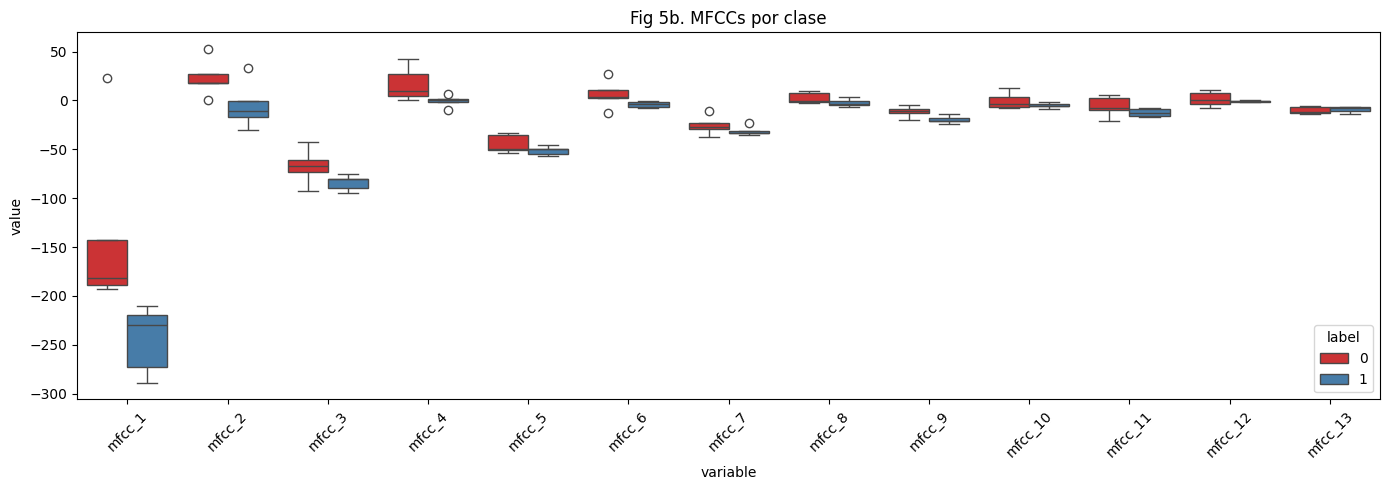

In [31]:
mfcc_cols = [f'mfcc_{i}' for i in range(1, 14)]
features_melted = features_df.melt(id_vars='label', value_vars=mfcc_cols)

plt.figure(figsize=(14, 5))
sns.boxplot(data=features_melted, x='variable', y='value', hue='label', palette='Set1')
plt.title("Fig 5b. MFCCs por clase")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()